In [1]:
%matplotlib inline

In [2]:
from __future__ import division

put your imports here

In [3]:
import numpy as np
import random as py_random
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear

sns.set(style="darkgrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [37]:
def examine_data_frame( df):
    for name in df.columns:
        print "----------"
        print df[ name].dtype
        if df[ name].dtype is np.dtype( 'O'):
            print df[ name].value_counts()
            print "Name: ", name
        else:
            print df[ name].describe()
            
# Graph stuff
def graph_boxplot(data):
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(1, 1, 1)
    patch = axes.boxplot(data, labels=["Samples"], patch_artist=True)
    restyle_boxplot(patch)
    x = np.random.normal(1, 0.01, size=len(data))
    axes.plot(x, data, 'o', alpha=0.4)
    plt.show()
   
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)
        
def graph_histogram(data, bins=None):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 2, 1)
    if bins == None:
        axes.hist(data)
    else:
        axes.hist(data, bins=bins)
    axes.set_ylabel( "Count")
    axes.set_xlabel( "Samples")
    axes = figure.add_subplot(1, 2, 2)
    if bins == None:
        axes.hist(data, normed=True)
    else:
        axes.hist(data, normed=True, bins=bins)
    axes.set_ylabel( "Density")
    axes.set_xlabel( "Samples")
    plt.show()
    
def graph_normal_ref(data):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    values, base = np.histogram(data, bins=11, density=True)
    cumulative = np.cumsum(values)
    axes.plot( base[:-1], cumulative, color="steelblue")
    axes.set_xlim((np.min(data), np.max(data)))
    weight_mean = np.mean(data)
    weight_std = np.std(data)
    sampled_data = [weight_mean + r * weight_std for r in np.random.standard_normal(10000)]
    values2, base = np.histogram( sampled_data, bins=base, density=True)
    cumulative2 = np.cumsum( values2)
    axes.plot( base[:-1], cumulative2, color="firebrick")
    axes.set_xlim((np.min(data), np.max(data)))
    axes.set_xlabel( "Empirical v. Theoretical: Normal Distribution")
    plt.show()
    
def graph_exp_ref(data, rate):
    beta = 1 / rate
    reference_data = np.random.exponential(scale=beta, size=10000)
    figure = plt.figure(figsize=(10,6))
    
    # First, plot empirical distribution
    axes = figure.add_subplot(1,1,1)
    axes.set_title("Comparison: {0} samples against reference distribution.".format(len(data)))
    values, base = np.histogram(data, density=True)
    cummulative = np.cumsum(values)
    axes.plot(base[:-1], cummulative, color='steelblue')
    
    # Second, plot the reference distribution
    values, base = np.histogram(reference_data, bins=base, density=True)
    cummulative = np.cumsum(values)
    axes.plot(base[:-1], cummulative, color='firebrick')
    
    axes.set_xlabel("Empirical v. Theoretical")
    plt.show()
    
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result
    
def bootstrap_lm( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = map( lambda x: x.strip(), formula.split("~")[1].split( "+"))
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in xrange( samples):
        sampling_indices = [ i for i in [py_random.randint(0, n - 1) for _ in xrange( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = lm( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r^2"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r^2")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = lm( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r^2"] = result[ "r^2"]
    return bootstrap_results

def describe_bootstrap_fit( result):
    print "regression: ", result[ "formula"]
    print "n: ", result[ "n"]
    print "----------"
    
    
    bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
        print variable + ": ", coefficient, bound
    print "----------"
    
    sigma_bounds = stats.mstats.mquantiles( result[ "resampled_sigma"], [0.025, 0.975])
    print "sigma", result[ "sigma"], sigma_bounds

    r_bounds = stats.mstats.mquantiles( result[ "resampled_r^2"], [0.025, 0.975])
    print "R^2", result[ "r^2"], r_bounds
    
def scale( df, variable):
    x_bar = df[ variable].mean()
    std = df[ variable].std()
    scaled_variable = (df[ variable] - x_bar) / (2.0 * std)
    df[ variable + "_scaled"] = scaled_variable

# Problem Set 3

## Directions

1. Show all work/steps/calculations. Generating Markdown cells for each answer or explanation as needed as well as Code cells for code. At minimum, you will be submitting 2 things:
    1. the .ipynb version of the notebook.
    2. the .html version of the notebook `$ jupyter nbconvert <name of notebook>.ipynb`. This is the copy that will be graded.
    
    You do not need to submit `heights.tsv` as long as you read/reference it from the same location as the notebook. Additionally, you must include any additional files or files in non-standard locations. For example, if you choose to move all the linear regression code to a library rather than include it in the notebook, you must include that library file.
    If we cannot run your code, the entire assignment is wrong, a "0". This is reproducible research.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results. Explain your decisions.** Why are you picking this procedure? Why are you defining the ROPE to be that size? What does a "90% Bayesian Confidence Interval" of (24.5, 27.8) *mean*?

This Problem Set involves EDA and linear regression. You should refer to the module notes for linear regression for function definitions and starter code (for example, plotting).

For this Problem Set, you will be using the `heights.tsv` file. This file contains the following columns (features):

* `earn` - During 1989, what was your personal income from your own wages, salary, or other sources, before taxes?
* `height1` - Height, feet.
* `height2` - Height, inches.
* `sex` - (Male, 1), (Female, 2)
* `race` - Are you (White, 1), (Black, 2), (Asian, 3), (Native American, 4), (Other, 5)
* `hispanic` - Are you hispanic? (Yes, 1), (No, 2)
* `ed` - What is the highest grade or year ln school that you have completed? (None, 0), (Elementary, 1-8), (High School 9-12), (College, 13-16), (Some Graduate School, 17), (Graduate School or Professional Degree, 18)
* `yearbn` - In what year were you born? 19\_\_
* `height` - Total height, in inches (computed from height1 and height2).

The data is from the *1990 Work, Family, and Well-Being Survey* (Ross, 1990), using only the columns `earn`, `height`, `sex`, `ed` and `yearbn`, we want to create a model that predicts `earn`.

For all questions that involve calculating a linear regression model, use `bootstrap_lm` and `describe_bootstrap_fit` from the Module notes. You will need to add Code and Markdown cells to this notebook in order to execute the code necessary to answer the questions as well as to provide all answers. **Clearly indicate what question you are answering**. **Please read all questions carefully before starting and make sure you understand what is being asked of you**.

1. Clean any unusually coded data (are binary and categorical variables coded usefully for linear regression?)
2. Perform EDA on the data set, note any patterns or problems you find.
3. Suppose you want to fit a model: `earn ~ height`. What sign do you expect $\beta_1$ (the coefficient on height) to have?
4. After fitting the model, what sign did $\beta_1$ have? Did the 95% credible interval for $\beta_1$ include 0? What is the interpretation of the $\beta_0$ (intercept) coefficient in this model? How can we improve the interpretability of the intercept term?
5. Suppose you want to fit the following model: `earn` explained by `height`, `sex`, `ed` and `yearbn`. What is your prior belief about the signs of the coefficients $\beta$s for your model? Fit the model.
6. Provide an interpretation of each coefficient from this model. Include a discussion of your "belief" in the value of the coefficient based on the 95% credible interval.
7. Plot the residuals against each of the numerical regressors. Is there a pattern that suggests a transformation would improve the regression?

The Problem Set will be graded based on the usual 3 point scale. Excellent will be based on the thoroughness and clarity of your answers for No. 1 - 7. There's a lot to do in Question 2, don't leave yourself short on time. Please remember, do not just execute the code. You must provide an interpretation of the results.

<b>Read in, clean data, and perform EDA<b>:

In [12]:
df = pd.read_csv('heights.tsv', sep='\t', header=0, usecols=['earn', 'height', 'sex', 'ed', 'yearbn'])
# Drop NA
df = df.dropna()
# 'sex', 'ed', 'yearbn' should be categorical columns
df['sex'] = df['sex'].astype('category')
df['ed'] = df['ed'].astype('category')
df['yearbn'] = df['yearbn'].astype('category')

In [6]:
# Check data types
print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1379 entries, 2 to 2028
Data columns (total 5 columns):
earn      1379 non-null float64
sex       1379 non-null category
ed        1379 non-null category
yearbn    1379 non-null category
height    1379 non-null float64
dtypes: category(3), float64(2)
memory usage: 37.1 KB
None


The dtypes of each column are set correctly, as seen from the output above. 'sex' and 'ed' are obvious categorical values and I think 'yearbn' should be too since a year of '89.234' doesn't exactly makes sense (even if it is a little reasonable). Next, I should figure out each column's min, max, mean, etc:

In [8]:
# Examine each column
examine_data_frame(df)

----------
float64
count      1379.000000
mean      20014.858593
std       19763.754808
min           0.000000
25%        6000.000000
50%       16400.000000
75%       28000.000000
max      200000.000000
Name: earn, dtype: float64
----------
category
count     1379
unique       2
top          2
freq       859
Name: sex, dtype: int64
----------
category
count     1379
unique      16
top         12
freq       520
Name: ed, dtype: int64
----------
category
count     1379
unique      73
top         58
freq        45
Name: yearbn, dtype: int64
----------
float64
count    1379.000000
mean       66.592458
std         3.805977
min        58.000000
25%        64.000000
50%        66.000000
75%        69.000000
max        77.000000
Name: height, dtype: float64


Based on the difference between the 75% quantile and the max of 'earn' it looks like that column might contain some outliers. I boxplot could better visual that data. 'ed', 'yearbn' and 'height' all look reasonable but we'll boxplot them just as a sanity check in a little while.

The split between male and female looks like it may be imbalanced so let's print their counts out:

In [32]:
# Test assumption: there should be about a 50-50 split of male and females
df['sex'].value_counts()

2    859
1    520
Name: sex, dtype: int64

This confirms the fact that the data includes almost double the number of females as males. This should be kept in mind when we make conclusions about the data later.

Next let's create boxplots for each variable.

earn


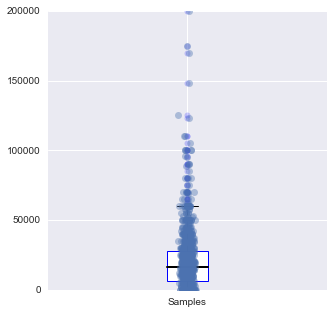

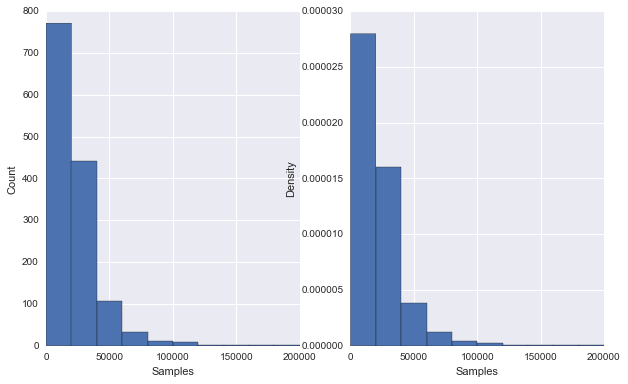

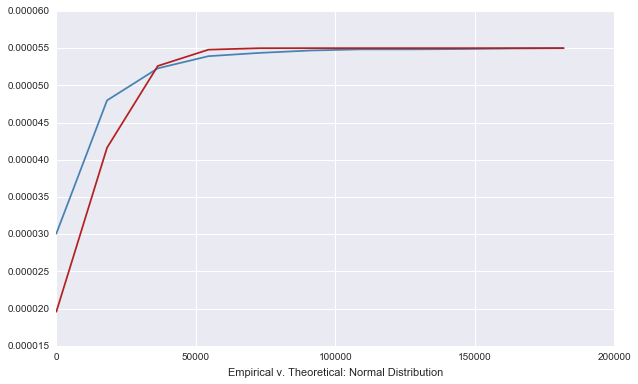

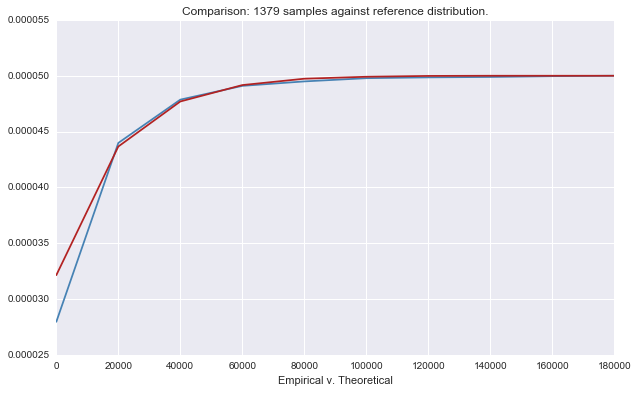

In [80]:
print "earn"
graph_boxplot(df['earn'].as_matrix())
graph_histogram(df['earn'].as_matrix())
graph_normal_ref(df['earn'].as_matrix())
graph_exp_ref(df['earn'].as_matrix(), .0000515)

As expected, the values begin thinning out around $110,000. This means the 'earn' column has about 7 outliers. In additional, the histogram reveals that the centrality of the 'earn' data is to the left and looks a little like it is exponentially distributed. The tigher fit for the exponential distribution is evidence of this.

sex


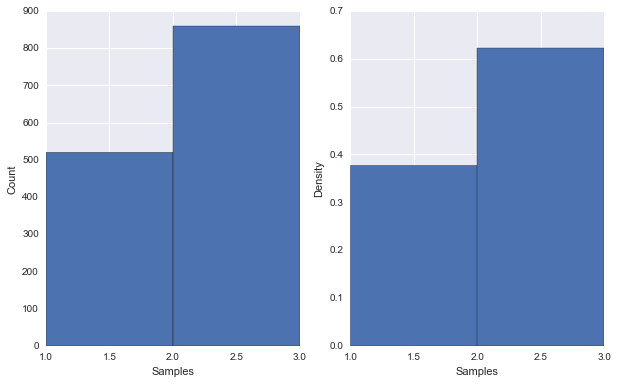

In [53]:
print "sex"
graph_histogram(df['sex'].as_matrix(), bins=[1,2,3])

The 'sex' histograms just reinforce the idea that more females are represented in this data than males.

ed


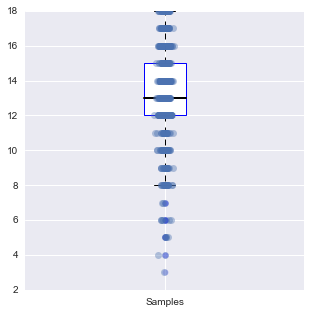

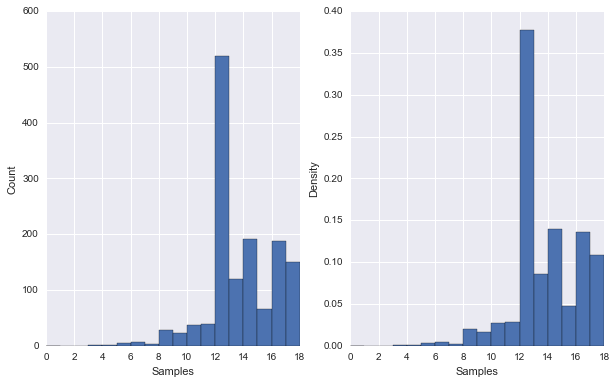

In [57]:
print "ed"
graph_histogram(df['ed'].as_matrix(), bins=range(0,19))

Whether the boxplot makes sense for this categorical variable is probably debatable but, in conjunction with the histograms, it shows that the most represented crowd in the data set is the post-high school/college crowd. The grade level with the highest count is 12th grade, meaning most people graduated high school, and the right centrality of the data says most probably took college classes. The second most common grade is 14 (2 years of college) and then 16 (under graduate degree). This may mean a lot of the participates are white-collar workers with office/professional jobs as opposed to blue-collar workers. 

yearbn


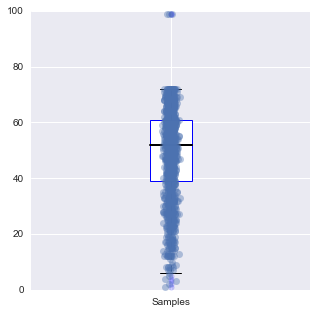

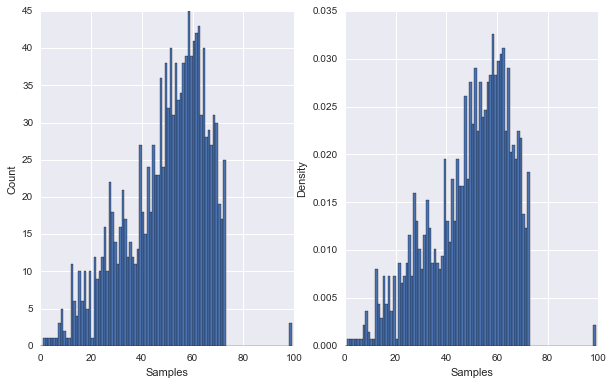

In [59]:
print "yearbn"
graph_histogram(df['yearbn'].as_matrix(), bins=range(0, 100))

This shows that the population in this data set was mainly born between 1940 - 1972. In 1990, the people born in 1972 would have been 18, which explains why most of our 'ed' data starts at 12th grade and leans heavily to the right.

If this data set was published in a 1990 report, it seems strange to me that about 4 people reported as being born after 1990. These are possible outliers.

height


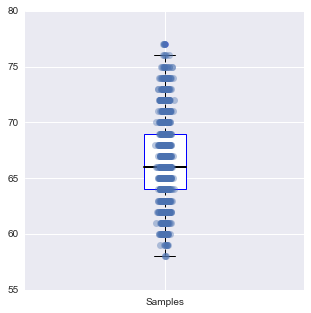

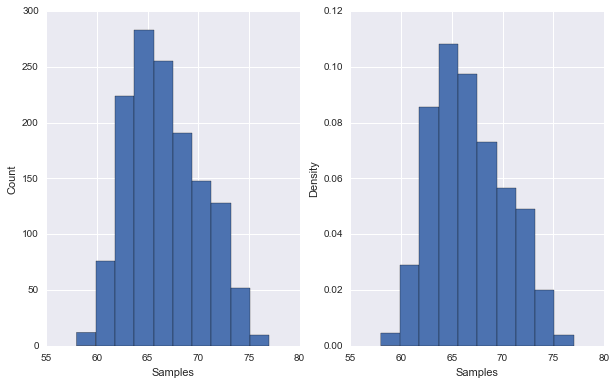

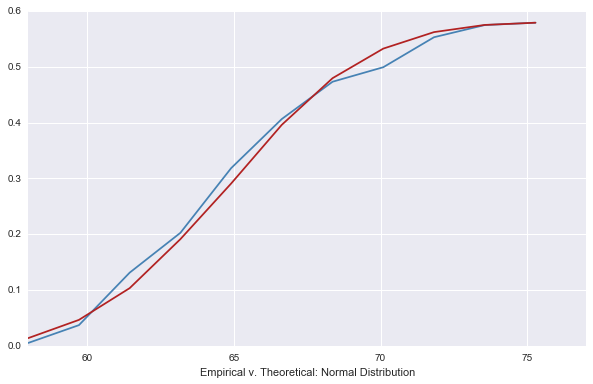

In [81]:
print "height"
graph_boxplot(df['height'].as_matrix())
graph_histogram(df['height'].as_matrix())
graph_normal_ref(df['height'].as_matrix())

The histograms for height peak at about 5 ft, 4 inches, which is about the average height of an adult woman. This peak is definitely influenced by the bias of female data instances in the data set. The histogram gradually decreases after the peak, which is probably were most of the males are represented. This would put the average male at about 5 ft, 10 inches, which is reasonable, especially considering we know the data is all adults.

In addition, height looks normally distribution, which is what we expect.

Now that we've gone through each variable individually, let's take a look at some relationships we expect to see in the data.

First, we expect to see height to be correlated to sex. That is, men are normally taller than women.

     count       mean       std   min   25%   50%   75%   max
sex                                                          
1    520.0  70.046154  2.946175  60.0  68.0  70.0  72.0  77.0
2    859.0  64.501746  2.531560  58.0  63.0  64.0  66.0  75.0


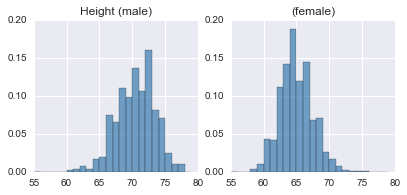

In [88]:
grouped = df.groupby( "sex")
height = grouped[ "height"].describe()
height = height.unstack( level=-1)
print height

bins = [i for i in xrange(55,80,1)]

figure = plt.figure(figsize=(10, 6))

for i, sex in enumerate([1,2]):
    axes = figure.add_subplot(2, 3, i + 1)
    data = grouped[ "height"].get_group( sex).values
    axes.hist( data, bins=bins, normed=True,alpha=0.75, color="steelblue")
    axes.set_title( "Height %s" % "(male)" if sex == 1 else "(female)")
    axes.set_ylim((0, 0.2))
    axes.set_xlim((55,80))
plt.show()

Although the difference isn't large (maybe because of the bias representation of male to female), we can see from the histograms grouped on sex that the male's centrality leans right of 67 inches and the female's leans left of 67. This is the relationship we were expecting.

Next, we expect earnings to be correlated positively to education.

    count          mean           std     min      25%      50%      75%       max
ed                                                                                
3     1.0   1400.000000           NaN  1400.0   1400.0   1400.0   1400.0    1400.0
4     2.0   6600.000000   7636.753237  1200.0   3900.0   6600.0   9300.0   12000.0
5     5.0   2340.000000   2752.816739     0.0      0.0   1200.0   4500.0    6000.0
6     7.0   7288.000000   7598.864477     0.0   2500.0   4416.0   9800.0   22000.0
7     3.0   8666.666667   9609.023537     0.0   3500.0   7000.0  13000.0   19000.0
8    28.0   9204.000000  10357.744413     0.0   1800.0   6250.0  14250.0   50000.0
9    23.0  10627.826087  12062.789877     0.0    300.0   7000.0  14000.0   38000.0
10   37.0  12141.081081  15271.316574     0.0      0.0   8000.0  18720.0   70000.0
11   39.0  15299.794872  14813.022065     0.0   1250.0  10000.0  27500.0   50000.0
12  520.0  15395.596154  13967.886112     0.0   4000.0  13000.0  23000.0  105000.0
13  

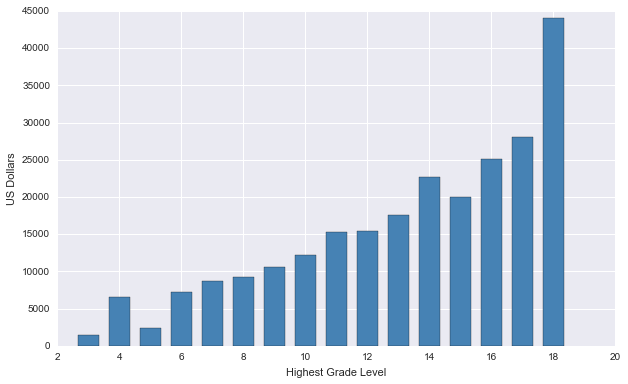

In [155]:
grouped = df.groupby( "ed")
earnings = grouped[ "earn"].describe()
earnings = earnings.unstack( level=-1)
print earnings

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar([i for i in xrange(3,19)], grouped["earn"].mean().as_matrix(), 1/1.5, color="steelblue", align="center")
axes.set_ylabel("US Dollars")
axes.set_xlabel("Highest Grade Level")
plt.show()

This bar chart clearly shows a positive relationship between grade level and earnings.

It is also possible for earnings to be correlated to sex (unfortunately).

     count          mean           std  min      25%      50%      75%       max
sex                                                                             
1    520.0  28926.915385  23494.745124  0.0  15000.0  25000.0  36000.0  200000.0
2    859.0  14619.899884  14702.287435  0.0   3000.0  12000.0  22000.0  123000.0


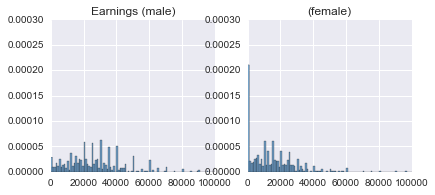

In [164]:
grouped = df.groupby( "sex")
earn = grouped[ "earn"].describe()
earn = earn.unstack( level=-1)
print earn

bins = [i for i in xrange(0,200000,1000)]

figure = plt.figure(figsize=(10, 6))

for i, sex in enumerate([1,2]):
    axes = figure.add_subplot(2, 3, i + 1)
    data = grouped[ "earn"].get_group( sex).values
    axes.hist( data, bins=bins, normed=True,alpha=0.75, color="steelblue")
    axes.set_title( "Earnings %s" % "(male)" if sex == 1 else "(female)")
    axes.set_ylim((0, 0.0003))
    axes.set_xlim((0,100000))
plt.show()

Although not super clear, the tail of the men's earnings extend a little bit longer than the female's.

Earn may also be correlated to age but I'm not sure this correlation will be strong so let's try it out.

        count       mean       std   min    25%   50%    75%   max
yearbn                                                            
1         1.0  67.000000       NaN  67.0  67.00  67.0  67.00  67.0
2         1.0  60.000000       NaN  60.0  60.00  60.0  60.00  60.0
3         1.0  63.000000       NaN  63.0  63.00  63.0  63.00  63.0
4         1.0  65.000000       NaN  65.0  65.00  65.0  65.00  65.0
5         1.0  58.000000       NaN  58.0  58.00  58.0  58.00  58.0
6         1.0  70.000000       NaN  70.0  70.00  70.0  70.00  70.0
7         3.0  61.000000  2.645751  59.0  59.50  60.0  62.00  64.0
8         5.0  65.000000  2.915476  61.0  64.00  65.0  66.00  69.0
9         2.0  68.000000  2.828427  66.0  67.00  68.0  69.00  70.0
10        1.0  65.000000       NaN  65.0  65.00  65.0  65.00  65.0
11        1.0  61.000000       NaN  61.0  61.00  61.0  61.00  61.0
12       11.0  65.090909  3.961175  61.0  62.50  63.0  66.50  74.0
13        6.0  65.166667  4.445972  60.0  61.75  65.5  67.00  

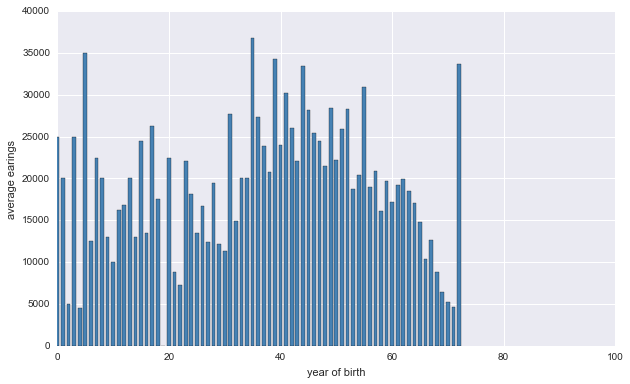

In [174]:
grouped = df.groupby( "yearbn")
earnings = grouped[ "earn"].describe()
earnings = earnings.unstack( level=-1)
print height

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar([i for i in xrange(grouped["earn"].mean().as_matrix().shape[0])], grouped["earn"].mean().as_matrix(), 1/1.5, color="steelblue", align="center")
axes.set_ylabel("average earings")
axes.set_xlabel("year of birth")
axes.set_xlim((0,100))
plt.show()

I wouldn't say there is a strong correlation between age and average earnings but it does look like the bulk of the distribution is settled between people from the age of 30 to 60, which is reasonable.

Height may be correlated with age.

        count       mean       std   min    25%   50%    75%   max
yearbn                                                            
1         1.0  67.000000       NaN  67.0  67.00  67.0  67.00  67.0
2         1.0  60.000000       NaN  60.0  60.00  60.0  60.00  60.0
3         1.0  63.000000       NaN  63.0  63.00  63.0  63.00  63.0
4         1.0  65.000000       NaN  65.0  65.00  65.0  65.00  65.0
5         1.0  58.000000       NaN  58.0  58.00  58.0  58.00  58.0
6         1.0  70.000000       NaN  70.0  70.00  70.0  70.00  70.0
7         3.0  61.000000  2.645751  59.0  59.50  60.0  62.00  64.0
8         5.0  65.000000  2.915476  61.0  64.00  65.0  66.00  69.0
9         2.0  68.000000  2.828427  66.0  67.00  68.0  69.00  70.0
10        1.0  65.000000       NaN  65.0  65.00  65.0  65.00  65.0
11        1.0  61.000000       NaN  61.0  61.00  61.0  61.00  61.0
12       11.0  65.090909  3.961175  61.0  62.50  63.0  66.50  74.0
13        6.0  65.166667  4.445972  60.0  61.75  65.5  67.00  

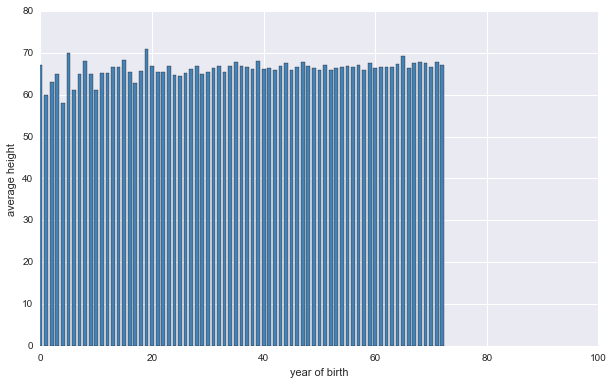

In [172]:
grouped = df.groupby( "yearbn")
height = grouped[ "height"].describe()
height = height.unstack( level=-1)
print height

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar([i for i in xrange(grouped["height"].mean().as_matrix().shape[0])], grouped["height"].mean().as_matrix(), 1/1.5, color="steelblue", align="center")
axes.set_ylabel("average height")
axes.set_xlabel("year of birth")
axes.set_xlim((0,100))
plt.show()

The correlation isn't strong but it is clear the younger people are the taller they are. This may be influenced by the number of men/women per age group.

     count  unique  top  freq
sex                          
1      520      65   58    19
2      859      70   51    32


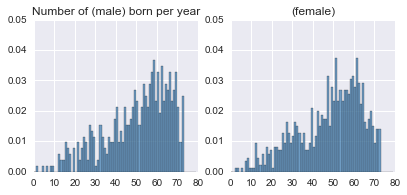

In [179]:
grouped = df.groupby( "sex")
height = grouped[ "yearbn"].describe()
height = height.unstack( level=-1)
print height

bins = [i for i in xrange(0,80,1)]

figure = plt.figure(figsize=(10, 6))

for i, sex in enumerate([1,2]):
    axes = figure.add_subplot(2, 3, i + 1)
    data = grouped[ "yearbn"].get_group( sex).values
    axes.hist( data, bins=bins, normed=True,alpha=0.75, color="steelblue")
    axes.set_title( "Number of %s born per year" % "(male)" if sex == 1 else "(female)")
    axes.set_ylim((0, 0.05))
    axes.set_xlim((0,80))
plt.show()

The number of births per year is the same for both male and females, which means we can rule out the idea that the data set has more younger men in it than older women, which could have resulted in the sex v height histogram above.

<b>Suppose you want to fit a model: earn ~ height. What sign do you expect  β1  (the coefficient on height) to have?</b><br>
-I'd expect the coefficient to be slightly above 0 and positive because we saw during the EDA phase that the centrality of sex v earning is slightly shifted to the right for male and we also saw that men are, on average, taller than women. Therefore, I think as the height increases, more men will make up the sample, and so positively influence earning.<br>

In [24]:
result = bootstrap_lm( "earn ~ height", data = df)
describe_bootstrap_fit(result)

regression:  earn ~ height
n:  1379
----------
intercept:  -84078.3234385 [-107257.04606296332, -66992.17351132662]
height:  1563.13769884 [1311.865150207199, 1916.3435422540238]
----------
sigma 18853.9174693 [ 16521.02863121  20756.47336149]
R^2 0.0906124349041 [ 0.06711442  0.14190083]


<b>After fitting the model, what sign did  β1  have? Did the 95% credible interval for  β1  include 0? What is the interpretation of the  β0  (intercept) coefficient in this model? How can we improve the interpretability of the intercept term?</b><br>

Judging by the poor R-squared and sigma value, my guess is that the relationship between earnings and height is non-linear. I'm also surprised at how large $\beta_{1}$ is, as I thought the relationship would be less correlated. Thinking on this a bit shows that for every inch of increase in height, we'd expect a person to make $1,563 more. This isn't as big of an increase as I inititally thought and falls closer to my hypothesis. It's important to note that since the sign was the same and the confidence interval doesn't include 0, we are certain height belongs in our model. The y-intercept also doesn't have a meaningful value in this case since it doesn't make sense to talk about something with a height of 0. Plotting (Y,X) and the residuals, we get the following:

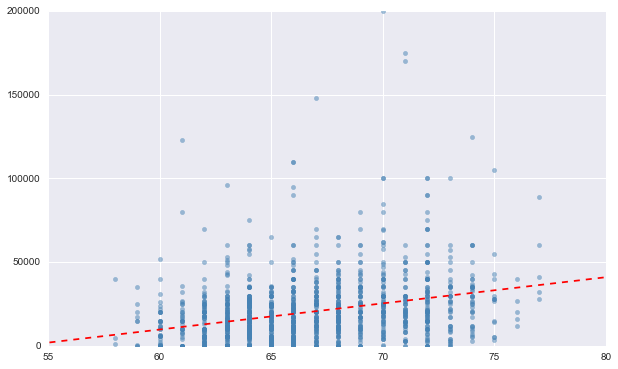

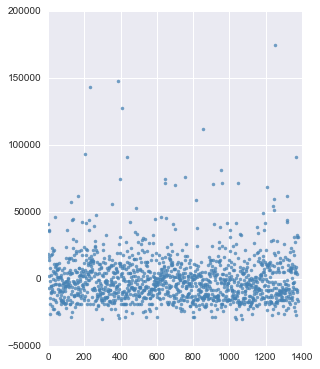

In [206]:
# Plot (Y,X)
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.scatter(df["height"].as_matrix(), df["earn"].as_matrix(), color="steelblue", alpha=0.5)
# Add trendline
z = np.polyfit(df["height"].as_matrix(), df["earn"].as_matrix(), 1)
p = np.poly1d(z)
plt.plot([i for i in xrange(len(df["height"].as_matrix()))],p([i for i in xrange(len(df["height"].as_matrix()))]), 'r--')
axes.set_xlim((np.min(df["height"].as_matrix())-3, np.max(df["height"].as_matrix())+3))
axes.set_ylim((np.min(df["earn"].as_matrix())-3, np.max(df["earn"].as_matrix())+3))
# Plot residuals
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 2, 1)
axes.plot(range(0, result[ "n"]), result[ "residuals"], '.', color="steelblue", alpha=0.75)

This shows that the residuals indeed are random, meaning our error is random and not dependent on a variable we haven't modeled for.<br>
To increase the intrepretibility of the intercept term in the original model, we can scale our continuous variables. So scaling the variables gets us:

In [23]:
scale(df, "height")
result = bootstrap_lm( "earn ~ height_scaled", data = df)
describe_bootstrap_fit(result)

regression:  earn ~ height_scaled
n:  1379
----------
intercept:  20014.8585932 [19037.396017654537, 21282.88437140685]
height_scaled:  11898.5311899 [10047.824015723872, 14494.848296041717]
----------
sigma 18853.9174693 [ 15913.64796976  20839.15976474]
R^2 0.0906124349041 [ 0.06647504  0.15501916]


Now we can intrepret the intercept directly: when height is at its mean of 0, then the average salary is $20,014.

<b>Suppose you want to fit the following model: earn explained by height, sex, ed and yearbn. What is your prior belief about the signs of the coefficients βs for your model? Fit the model.</b>

For the reasons mentioned above, I'd expect height to have a positive relationship with earnings. Likewise, I'd expect education level to have a positive relationship on earnings. During EDA, we saw that earnings between men and women were slightly bias towards men of the same age earning more. As a result, I'd expect the coefficient for sex, since male = 1 and female = 2, to be slightly negative. Lastly, we saw that age and earnings are positively correlated up until about an age of ~60, when people start retiring. Since non-retirement years dominated retirement years, I expect this coefficient to have a positive sign.

In [38]:
df = pd.read_csv( "heights.tsv", sep="\t") # not sure why I have to do this again but the data frame got corrupted or something.
result = bootstrap_lm( "earn ~ sex + ed + yearbn + height", data = df)
describe_bootstrap_fit(result)

regression:  earn ~ sex + ed + yearbn + height
n:  2029
----------
intercept:  -18303.6375588 [-43080.472279995534, 7324.719909469011]
sex:  -11465.0644466 [-13833.766676838282, -8850.741420986287]
ed:  2760.82575822 [2241.338334776912, 3153.2430039784845]
yearbn:  -171.938253074 [-221.89398795695018, -123.44024579333256]
height:  427.398007291 [58.14902657250377, 729.9242928718604]
----------
sigma 17127.1635728 [ 15026.54440948  18400.34283112]
R^2 0.251193696873 [ 0.22274057  0.28129434]


<b>Provide an interpretation of each coefficient from this model. Include a discussion of your "belief" in the value of the coefficient based on the 95% credible interval.</b>

<b>Interpretation of $\beta_{0}$:</b> Since it isn't meaningful to talk of a height equal to 0, the intercept doesn't have a clear interpretation. As far as my belief in the value of the coefficient, the value is right in the middle of the 95\% confidence interval so it safe to say this is a reasonable value. With that being said, the range is rather large, which makes be leery of the value.<br>
<b>Interpretation of $\beta_{1}$:</b> Since in our data set male = 1 and female = 2, $\beta_{1}$ represents the, on average, that women of the same education level, age, and height earn \$11,465 less than men. Based on my earlier high-level EDA on this relationship, this value is much higher than I thought it would be but the confidence interval is only about \$5000 wide so I think it is reasonable.<br>
<b>Interpretation of $\beta_{2}$:</b> This coefficient means, assuming someone's sex, age and height doesn't change, that someone would expect to make \$2760.83 more if they increase their education 'level' by 1. Since our education levels are grouped, this doesn't mean a person graduating from the 8th, instead of the 7th grade, would earn more. Based on the range of the confidence interval, I'm confident this is a reasonable value.<br>
<b>Interpretation of $\beta_{3}$:</b> This coefficient means, assuming someone's sex, education level and height doesn't change, each year someone ages they can expect to make \$171.92 less. Although this makes sense after people retire, a worker in his/her 30s is in their prime and I don't see this relationship at all. Even with the 95\% confidence interval, I'd expect a number closer to zero.
<b>Interpretation of $\beta_{4}$:</b> This coefficient means, assuming someone's sex, education level, and age stayed the same, a person should expect to earn \$427.40 more for every inch they grow. Although this would be nice, given the large range and the fact that raises don't work like that, I don't have much confidence in its value.

<b>Plot the residuals against each of the numerical regressors. Is there a pattern that suggests a transformation would improve the regression?</b>

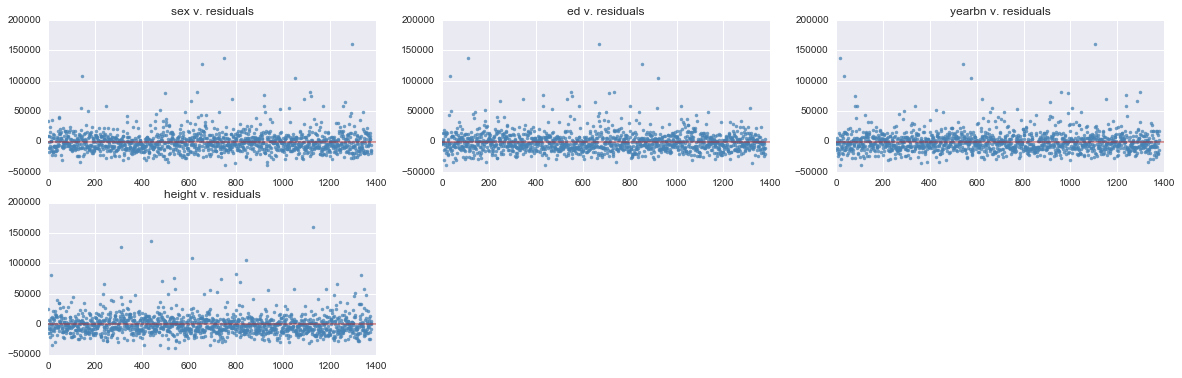

In [43]:
figure = plt.figure(figsize=(20,6))

variables = ["sex", "ed", "yearbn", "height"]

plots = len( variables)
rows = (plots // 3) + 1
for i, variable in enumerate( variables):
    axes = figure.add_subplot(rows, 3, i + 1)

    keyed_values = sorted( zip( df[ variable].values, result[ "residuals"]), key=lambda x: x[ 0])
    residuals = map( lambda x: x[ 1][ 0], keyed_values)
    
    axes.plot(range(0, result["residuals"].shape[0]), residuals, '.', color="steelblue", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

There isn't a strong pattern overall, which means there isn't a transformation that would benefit the model.